# Tiling experiments

The 2D U-Net model was trained on the BraTS 2018 dataset to predict the whole tumor using the FLAIR channel of the raw MRI. We scaled the FLAIR channel by subtracting the mean value and dividing by the standard deviation. We then trained the model using a center-cropped patch of size 128x128 from the original 240x240 image. Only 2D slices were considered. Our final Dice metric was 0.84 on the test dataset.

This code shows the results of performing inference on overlapping tiles of the original image versus infering on the entire 240x240 image. Our results show that there are many false positive tumor predictions caused by the tiling method which can be mitigated (but not fully resolved) using a high degree of overlap and a large tile size. We conclude that using the full image size for inference is preferable to reduce the false positive rate.

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"   # For GPU

import keras
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

%matplotlib inline

Using TensorFlow backend.


In [2]:
def dice(msk, pred):
    """
    Dice coefficient
    """
    smooth = 1.0
    
    numerator = 2.0 * np.sum(msk*pred) + smooth
    denominator = np.sum(msk)+np.sum(pred) + smooth 
    
    
    return numerator/denominator

## Load the model

The model is a 2D U-Net (with batch norm) that was trained on a center-cropped patch of size 128x128 from the original FLAIR channel of the MRI. 

In [3]:
model = keras.models.load_model("model128x128_from_whole/unet_model_upsampling_128x128_from_whole.hdf5")

## Load the full size image and masks

In [5]:
data_path = "../../data/Brats2018/"
#data_path = "/mnt/data/medical/brats/Brats2018/"

#imgs128x128 = np.load(os.path.join(data_path, "128x128/imgs_test.npy"), mmap_mode="r", allow_pickle=False)
#msks128x128 = np.sum(np.load(os.path.join(data_path, "128x128/msks_test.npy"), mmap_mode="r", allow_pickle=False), axis=-1)

#imgs240x240 = np.load(os.path.join(data_path, "240x240/imgs_test.npy"), mmap_mode="r", allow_pickle=False)
#msks240x240 = np.sum(np.load(os.path.join(data_path, "240x240/msks_test.npy"), mmap_mode="r", allow_pickle=False), axis=-1)

import h5py 

hdfFile = h5py.File(os.path.join(data_path, "240x240/processed_data.hdf5"), "r")
imgs240x240 = hdfFile["images/test"]
msks240x240 = hdfFile["masks/test"]


## Tiling algorithm

The original 240x240 image (2D slice) is broken into equally-sized, overlapping tiles. We perform inference on each tile and add its prediction to the combined mask prediction. The final combined prediction is scaled to account for the overlapping predictions.

In [22]:
def predict_tiles(slice_id, model, imgs, patchx, patchy, stepx, stepy):

    # 2371, 230, 6200, 5550, 791, 55, 1915, 1775, 987, 980, 1788
    # Counter? 1533, 1770, 730, 1368
    # 1372 is interesting case
    # 1527 and 1533 are exact counter examples from same scan

    """
    230 is very nice example where Dice doesn't tell the story.
    The Dice is better for the tiled, but the tiled prediction
    misses a separate tumor in the image (but whole image prediction)
    catches it.
    """
    maxx = imgs.shape[1]  # Width of whole image
    maxy = imgs.shape[2]  # Height of whole image

    patches = {}
    idx = 0

    full_image = model.predict(np.expand_dims(imgs[slice_id:(slice_id+1),:,:,2], -1), verbose=0)

    combined = np.zeros((maxx,maxy))
    scaled = np.zeros((maxx,maxy))

    tile_counter = 0

    while (idx < maxx):

        idy = 0
        while (idy < maxy):

            tile_counter += 1

            if (idx < (maxx-patchx)):
                x = idx
            else:
                x = maxx - patchx
                idx = maxx

            if (idy < (maxy-patchy)):
                y = idy
            else:
                y = maxy - patchy
                idy = maxy

            p = model.predict(np.expand_dims(imgs[slice_id:(slice_id+1),x:(x+patchx),y:(y+patchy),2], -1), verbose=0)
            
            patches[tile_counter] = p
            
            combined[x:(x+patchx),y:(y+patchy)] += p[0,:,:,0]

            # Scaled gives us a count of how many patches we have overlaid
            # This way we can divide by that number to get the average prediction
            # for that pixel.
            scaled[x:(x+patchx),y:(y+patchy)] += np.ones((patchx, patchy))

            idy += stepy

        idx += stepx
        
    combined /= scaled  # Divide to get the average prediction for the pixel
    
    threshold = combined.copy()
    threshold[threshold < 0.5] = 0.0  # Get rid of anything less than 0.5

    return combined, threshold, full_image, tile_counter, patches


In [7]:
patchx = 128  # Width of tile for inference (1 to maxx)
patchy = 128  # Height of tile for inference (1 to maxy)
stepx = 64  # How many pixels to slide in x direction (1 to patchx-1)
stepy = 64  # How many pixels to slide in y direction (1 to patchy-1)

In [7]:
msks240x240.shape

(8215, 240, 240, 4)

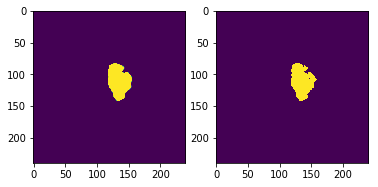

In [10]:
slice_id = 4150
combined, threshold, full_image, tile_counter = predict_tiles(slice_id, model, imgs240x240, patchx, patchy, stepx, stepy)
plt.subplot(1,2,1)
plt.imshow(full_image[0,:,:,0])
plt.subplot(1,2,2)
plt.imshow(np.sum(msks240x240[slice_id,:,:,:], axis=2))

In [11]:
tiled_dice = np.zeros(imgs240x240.shape[0])
threshold_dice = np.zeros(imgs240x240.shape[0])
full_image_dice = np.zeros(imgs240x240.shape[0])

for slice_id in tqdm(range(imgs240x240.shape[0])):
    
    combined, threshold, full_image, tile_counter = predict_tiles(slice_id, model, imgs240x240, patchx, patchy, stepx, stepy)

    tiled_dice[slice_id] = dice(np.sum(msks240x240[slice_id,:,:,:], axis=2),combined)
    threshold_dice[slice_id] = dice(np.sum(msks240x240[slice_id,:,:,:], axis=2),threshold)
    full_image_dice[slice_id] = dice(np.sum(msks240x240[slice_id,:,:,:], axis=2),full_image[0,:,:,0])     


100%|██████████| 8215/8215 [35:39<00:00,  3.84it/s]


In [8]:
#np.savez("128x128_half.npz", tiled_dice=tiled_dice, threshold_dice=threshold_dice, full_image_dice = full_image_dice)

with np.load("128x128_half.npz") as data:
    threshold_dice = data["threshold_dice"]
    tiled_dice = data["tiled_dice"]
    full_image_dice = data["full_image_dice"]

In [9]:
# import seaborn as sns
# sns.set_style("white")

Mean Full image prediction Thresholded Dice metric is 0.011 tiled Dice prediction


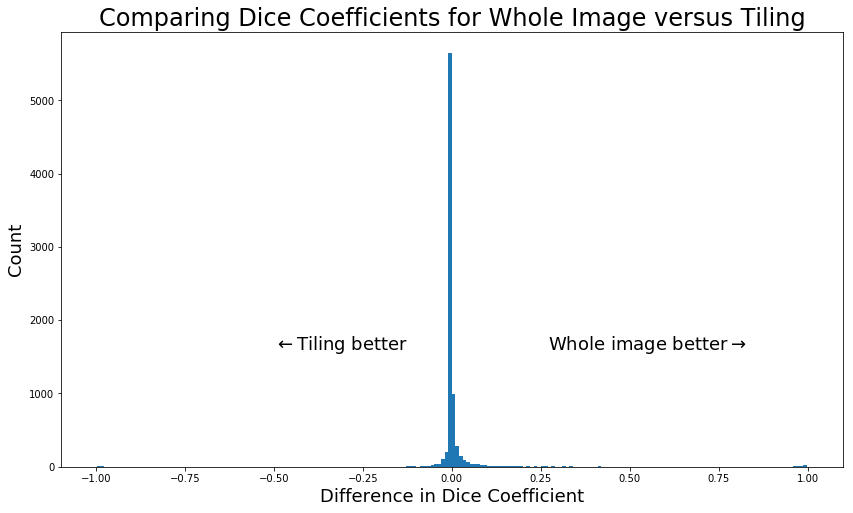

In [10]:
plt.figure(figsize=(14,8))
plt.hist(full_image_dice-threshold_dice, 200);
plt.text(0.27,1600,r"Whole image better$\rightarrow$", fontsize=18)
plt.text(-0.5,1600,r"$\leftarrow$Tiling better", fontsize=18)
plt.xlabel("Difference in Dice Coefficient", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.title("Comparing Dice Coefficients for Whole Image versus Tiling", fontsize=24)
print("Mean Full image prediction Thresholded Dice metric is {:.3f} tiled Dice prediction".format(np.mean(full_image_dice-threshold_dice)))

Mean Full image prediction Dice metric is 0.045 tiled Dice prediction


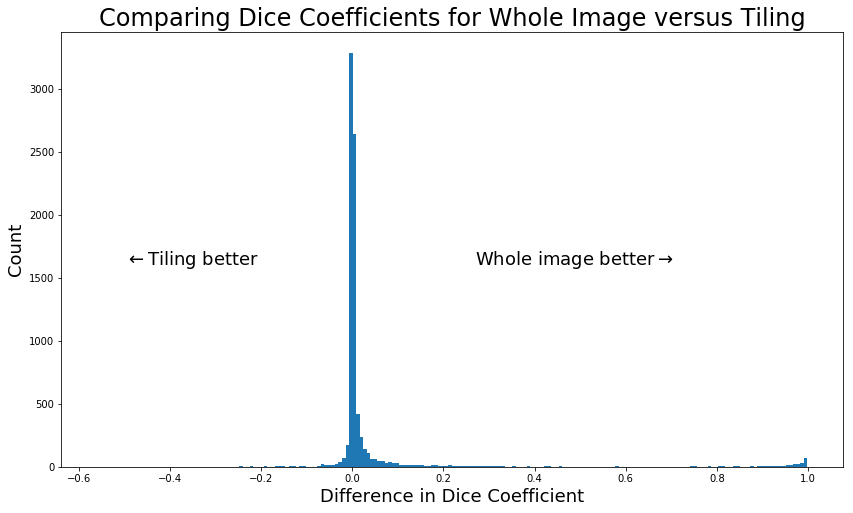

In [11]:
plt.figure(figsize=(14,8))
plt.hist(full_image_dice-tiled_dice, 200);
plt.text(0.27,1600,r"Whole image better$\rightarrow$", fontsize=18)
plt.text(-0.5,1600,r"$\leftarrow$Tiling better", fontsize=18)
plt.xlabel("Difference in Dice Coefficient", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.title("Comparing Dice Coefficients for Whole Image versus Tiling", fontsize=24)
print("Mean Full image prediction Dice metric is {:.3f} tiled Dice prediction".format(np.mean(full_image_dice-tiled_dice)))

## Go through some good predictions and show images

In [29]:
import ipywidgets as widgets


good_id = np.intersect1d(np.where((full_image_dice-threshold_dice) > 0.2)[0],
                          np.where((full_image_dice-threshold_dice) < 0.7)[0])

def plt_predictions(idx):
    
    slice_id = good_id[idx]
    
    stepx = 64
    stepy = 64
    patchx = 128
    patchy = 128
    
    combined, threshold, full_image, tile_counter, patches = predict_tiles(slice_id, model, imgs240x240, patchx, patchy, stepx, stepy)

    plt.figure(figsize=(14,14))
    plt.subplot2grid((2, 3), (0, 0), colspan=3)
    plt.imshow(imgs240x240[slice_id,:,:,2], cmap="bone");
    plt.title("MRI");
    plt.subplot2grid((2, 3), (1, 1));
    plt.imshow(np.sum(msks240x240[slice_id,:,:],axis=2), vmin=0, vmax=1);
    plt.title("Ground truth");
    plt.subplot2grid((2, 3), (1, 0));
    plt.imshow(combined, vmin=0, vmax=1);
    plt.title("Tiled {}x{} patches\nOverlap={:.1f}% ({} pixels)".format(patchx,
                                                                        patchy,
                                                                        (100.0-100.0*stepx/patchx),
                                                                        patchx - stepx));
    plt.subplot2grid((2, 3), (1, 2));
    plt.imshow(full_image[0,:,:,0]);
    plt.title("Predicted on whole image");

    print("Number of tile calculations = {}".format(tile_counter))

#plt_predictions(100)
widgets.interact(plt_predictions, idx=widgets.IntSlider(min=0,max=good_id.shape[0],step=1,value=10));

interactive(children=(IntSlider(value=10, description='idx', max=68), Output()), _dom_classes=('widget-interac…

Number of tile calculations = 9
Tiled Dice = 0.0021
Thresholded tiling Dice = 0.0045
Whole image Dice = 0.4972
Full is better or equal.


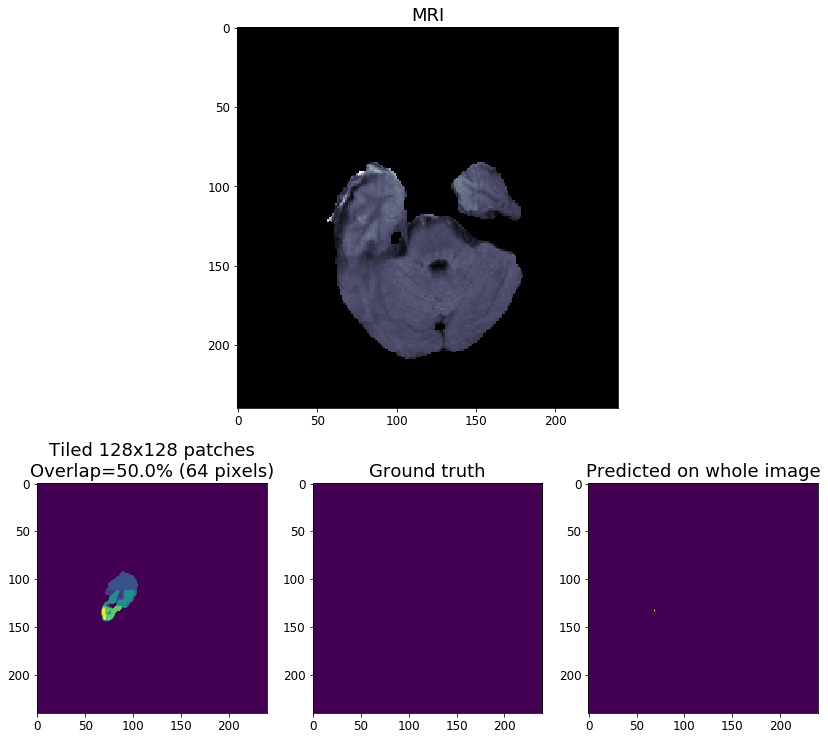

In [64]:
def predict_one(slice_id):
    
    stepx = 64
    stepy = 64
    patchx = 128
    patchy = 128
    combined, threshold, full_image, tile_counter, patches = predict_tiles(slice_id, model, imgs240x240, patchx, patchy, stepx, stepy)
    plt.figure(figsize=(14,14))
    plt.subplot2grid((2, 3), (0, 0), colspan=3)
    plt.imshow(imgs240x240[slice_id,:,:,2], cmap="bone");
    plt.tick_params(axis = "both", which = "major", labelsize = 12)
    plt.title("MRI", fontsize=18);
    plt.subplot2grid((2, 3), (1, 1));
    plt.imshow(np.sum(msks240x240[slice_id,:,:], axis=2), vmin=0, vmax=1);
    plt.tick_params(axis = "both", which = "major", labelsize = 12)
    plt.title("Ground truth", fontsize=18);
    plt.subplot2grid((2, 3), (1, 0));
    plt.imshow(combined, vmin=0, vmax=1);
    plt.tick_params(axis = "both", which = "major", labelsize = 12)
    plt.title("Tiled {}x{} patches\nOverlap={:.1f}% ({} pixels)".format(patchx,
                                                                        patchy,
                                                                        (100.0-100.0*stepx/patchx),
                                                                        patchx - stepx), fontsize=18);
    plt.subplot2grid((2, 3), (1, 2));
    plt.imshow(full_image[0,:,:,0]);
    plt.tick_params(axis = "both", which = "major", labelsize = 12)
    plt.title("Predicted on whole image", fontsize=18);

    print("Number of tile calculations = {}".format(tile_counter))

    tiled_dice = dice(np.sum(msks240x240[slice_id,:,:],axis=2),combined)
    threshold_dice = dice(np.sum(msks240x240[slice_id,:,:],axis=2),threshold)
    full_image_dice = dice(np.sum(msks240x240[slice_id,:,:],axis=2),full_image[0,:,:,0])     

    print("Tiled Dice = {:.4f}".format(tiled_dice))
    print("Thresholded tiling Dice = {:.4f}".format(threshold_dice))
    print("Whole image Dice = {:.4f}".format(full_image_dice))

    if (full_image_dice >= threshold_dice):
        print("Full is better or equal.")
    else:
        print("Threshold tiled is better.")
        
    # Reduce space between rows
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0)
    

# 2755, 6733, 7659, 7829, 7830, 8137, 349, 5660
        
#predict_one(8137) # false negative 1
#predict_one(2755) # false negative 2
#predict_one(7829) # false negative 3
#predict_one(8137) # false negative 4
predict_one(349)   # false positive 1

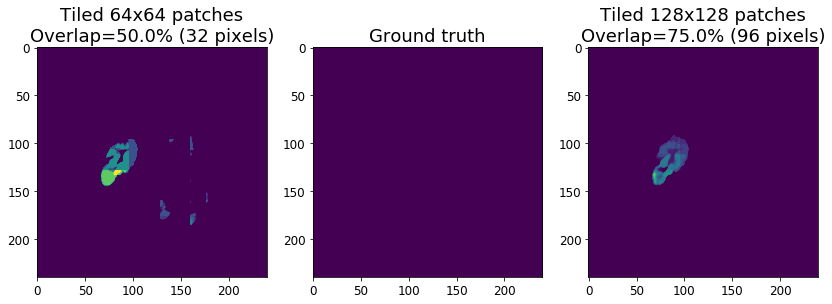

In [18]:
def predict_different_patch_sizes(slice_id):
    
    stepx = 32
    stepy = 32
    patchx = 64
    patchy = 64
    combined, threshold, full_image, tile_counter = predict_tiles(slice_id, model, imgs240x240, patchx, patchy, stepx, stepy)
    plt.figure(figsize=(14,14))
    plt.subplot2grid((1, 3), (0, 1));
    plt.imshow(np.sum(msks240x240[slice_id,:,:,:], axis=2), vmin=0, vmax=1);
    plt.tick_params(axis = "both", which = "major", labelsize = 12)
    plt.title("Ground truth", fontsize=18);
    plt.subplot2grid((1, 3), (0, 0));
    plt.imshow(combined, vmin=0, vmax=1);
    plt.tick_params(axis = "both", which = "major", labelsize = 12)
    plt.title("Tiled {}x{} patches\nOverlap={:.1f}% ({} pixels)".format(patchx,
                                                                        patchy,
                                                                        (100.0-100.0*stepx/patchx),
                                                                        patchx - stepx),fontsize=18);
    stepx = 32
    stepy = 32
    patchx = 128
    patchy = 128
    combined, threshold, full_image, tile_counter, patches = predict_tiles(slice_id, model, imgs240x240, patchx, patchy, stepx, stepy)
    plt.subplot2grid((1, 3), (0, 2));
    plt.imshow(combined, vmin=0, vmax=1);
    plt.tick_params(axis = "both", which = "major", labelsize = 12)
    plt.title("Tiled {}x{} patches\nOverlap={:.1f}% ({} pixels)".format(patchx,
                                                                        patchy,
                                                                        (100.0-100.0*stepx/patchx),
                                                                        patchx - stepx),fontsize=18);
    
    
        
predict_different_patch_sizes(349) #false_positive1_moreoverlap_smaller_patches


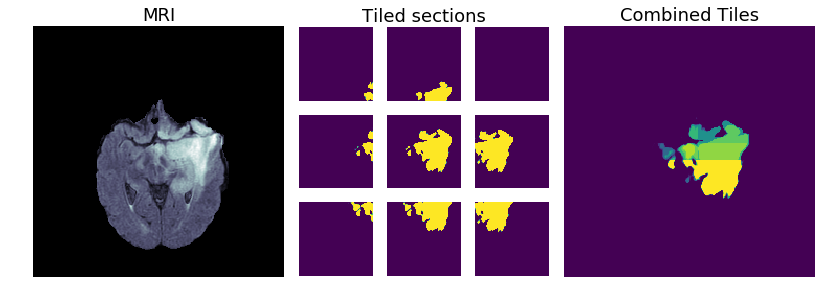

In [118]:
slice_id = 7190 #3804, 349, 7190
combined, threshold, full_image, tile_counter, patches = predict_tiles(slice_id, model, imgs240x240, patchx, patchy, stepx, stepy)

plt.figure(figsize=(14,14))
plt.subplot2grid((3, 9), (0, 3));
plt.imshow(patches[1][0,:,:,0], vmin=0, vmax=1);
plt.axis("off");
plt.subplot2grid((3, 9), (0, 4));
plt.imshow(patches[2][0,:,:,0], vmin=0, vmax=1);
plt.title("Tiled sections", fontsize=18)
plt.axis("off");
plt.subplot2grid((3, 9), (0, 5));
plt.imshow(patches[3][0,:,:,0], vmin=0, vmax=1);
plt.axis("off");

plt.subplot2grid((3, 9), (1, 3));
plt.imshow(patches[4][0,:,:,0], vmin=0, vmax=1);
plt.axis("off");
plt.subplot2grid((3, 9), (1, 4));
plt.imshow(patches[5][0,:,:,0], vmin=0, vmax=1);
plt.axis("off");
plt.subplot2grid((3, 9), (1, 5));
plt.imshow(patches[6][0,:,:,0], vmin=0, vmax=1);
plt.axis("off");

plt.subplot2grid((3, 9), (2, 3));
plt.imshow(patches[7][0,:,:,0], vmin=0, vmax=1);
plt.axis("off");
plt.subplot2grid((3, 9), (2, 4));
plt.imshow(patches[8][0,:,:,0], vmin=0, vmax=1);
plt.axis("off");
plt.subplot2grid((3, 9), (2, 5));
plt.imshow(patches[9][0,:,:,0], vmin=0, vmax=1);
plt.axis("off");

plt.subplot2grid((3,9),(0,6),rowspan=3,colspan=3)
plt.imshow(combined);
plt.title("Combined Tiles", fontsize=18)
plt.axis("off");

plt.subplot2grid((3,9),(0,0),rowspan=3,colspan=3)
plt.imshow(imgs240x240[slice_id,:,:,2], cmap="bone");
plt.title("MRI", fontsize=18)
plt.axis("off");

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=-.85);
